# Patient-Based Sleep Apnea Detection Validation
## Proper validation methodology for sleep apnea detection using acoustic features
### Key improvements: Patient-based splits, medical metrics, robust evaluation

In [23]:
# Cell 1: Imports and Setup
print("--- Setting up patient-based validation environment ---")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GroupKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, roc_auc_score, 
    precision_score, recall_score, accuracy_score, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import xgboost as xgb
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette("husl")

print("✅ Libraries loaded successfully!")
print("🏥 Focus: Medical-grade validation with patient-based splits")

--- Setting up patient-based validation environment ---
✅ Libraries loaded successfully!
🏥 Focus: Medical-grade validation with patient-based splits


In [24]:
# Cell 2: Load and Analyze Dataset
print("--- Loading and analyzing sleep apnea dataset ---")

# Load the threading dataset (full 6-patient dataset)
DATASET_PATH = '../data/datasets/final_local_dataset.csv'

try:
    df = pd.read_csv(DATASET_PATH)
    print(f"✅ Dataset loaded successfully!")
    dataset_loaded = True
except FileNotFoundError:
    print(f"❌ Dataset not found: {DATASET_PATH}")
    print("Please run the multi-EDF feature extraction first.")
    dataset_loaded = False

if dataset_loaded:
    print(f"\n📊 DATASET OVERVIEW:")
    print(f"{'='*60}")
    print(f"Shape: {df.shape}")
    print(f"Patients: {df['patient_id'].nunique()}")
    print(f"Total frames: {len(df):,}")
    print(f"Frame duration: {df['frame_duration'].iloc[0]} seconds")
    
    # Patient distribution
    patient_counts = df['patient_id'].value_counts().sort_index()
    print(f"\n👥 PER-PATIENT FRAME COUNTS:")
    for patient, count in patient_counts.items():
        print(f"  {patient}: {count:,} frames")
    
    # Apnea analysis
    overall_apnea_rate = df['apnea_label'].mean()
    print(f"\n🚨 APNEA ANALYSIS:")
    print(f"Overall apnea rate: {overall_apnea_rate:.1%}")
    
    # Per-patient apnea rates
    patient_apnea_stats = df.groupby('patient_id')['apnea_label'].agg(['mean', 'sum', 'count']).round(3)
    print(f"\nPer-patient apnea rates:")
    for patient in patient_apnea_stats.index:
        rate = patient_apnea_stats.loc[patient, 'mean']
        count = int(patient_apnea_stats.loc[patient, 'sum'])
        total = int(patient_apnea_stats.loc[patient, 'count'])
        severity = 'Severe' if rate > 0.3 else 'Moderate' if rate > 0.15 else 'Mild'
        print(f"  {patient}: {rate:.1%} ({count}/{total} frames) - {severity}")
    
    # Feature overview
    feature_cols = [col for col in df.columns if col.startswith('clean_')]
    metadata_cols = ['patient_id', 'edf_file', 'timestamp', 'frame_duration', 'apnea_label', 'apnea_proportion']
    
    print(f"\n🎯 FEATURE OVERVIEW:")
    print(f"Total features: {len(feature_cols)}")
    print(f"Metadata columns: {len(metadata_cols)}")
    
    # Data quality checks
    print(f"\n🔍 DATA QUALITY:")
    print(f"Missing values: {df[feature_cols].isnull().sum().sum()}")
    print(f"Infinite values: {np.isinf(df[feature_cols]).sum().sum()}")
    print(f"Zero variance features: {(df[feature_cols].std() == 0).sum()}")
    
    print(f"\n✅ Dataset analysis complete!")
else:
    print("❌ Cannot proceed without dataset")

--- Loading and analyzing sleep apnea dataset ---
✅ Dataset loaded successfully!

📊 DATASET OVERVIEW:
Shape: (28937, 34)
Patients: 24
Total frames: 28,937
Frame duration: 30.0 seconds

👥 PER-PATIENT FRAME COUNTS:
  patient_01: 988 frames
  patient_02: 1,052 frames
  patient_03: 900 frames
  patient_04: 1,126 frames
  patient_05: 981 frames
  patient_06: 989 frames
  patient_07: 1,816 frames
  patient_08: 999 frames
  patient_09: 1,290 frames
  patient_10: 965 frames
  patient_11: 870 frames
  patient_12: 950 frames
  patient_13: 727 frames
  patient_14: 1,372 frames
  patient_15: 871 frames
  patient_16: 902 frames
  patient_17: 1,389 frames
  patient_18: 1,390 frames
  patient_19: 1,724 frames
  patient_20: 1,573 frames
  patient_21: 1,739 frames
  patient_22: 1,779 frames
  patient_23: 1,610 frames
  patient_24: 935 frames

🚨 APNEA ANALYSIS:
Overall apnea rate: 57.2%

Per-patient apnea rates:
  patient_01: 41.1% (406/988 frames) - Severe
  patient_02: 31.1% (327/1052 frames) - Severe

In [25]:
# Cell 3: Patient-Based Train/Test Split
print("--- Creating patient-based train/test splits ---")

if dataset_loaded:
    # Get unique patients
    patients = df['patient_id'].unique()
    n_patients = len(patients)
    
    print(f"\n👥 PATIENT-BASED SPLITTING:")
    print(f"Total patients: {n_patients}")
    
    # Check patient apnea rates for stratified splitting
    patient_severity = df.groupby('patient_id')['apnea_label'].mean()
    severe_patients = patient_severity[patient_severity > 0.3].index.tolist()
    moderate_patients = patient_severity[(patient_severity > 0.15) & (patient_severity <= 0.3)].index.tolist()
    mild_patients = patient_severity[patient_severity <= 0.15].index.tolist()
    
    print(f"\n📊 PATIENT SEVERITY DISTRIBUTION:")
    print(f"Severe (>30%): {len(severe_patients)} patients - {severe_patients}")
    print(f"Moderate (15-30%): {len(moderate_patients)} patients - {moderate_patients}")
    print(f"Mild (<15%): {len(mild_patients)} patients - {mild_patients}")
    
    # Create patient-based splits (trying to balance severity)
    np.random.seed(42)  # For reproducibility
    
    if n_patients >= 4:
        # For 6 patients: 4 train, 2 test
        n_test = max(1, n_patients // 3)  # At least 1 test patient
        n_train = n_patients - n_test
        
        # Stratified patient selection (try to balance severity in train/test)
        test_patients = []
        train_patients = []
        
        # Distribute patients to maintain severity balance
        all_patients_shuffled = np.random.permutation(patients)
        test_patients = all_patients_shuffled[:n_test].tolist()
        train_patients = all_patients_shuffled[n_test:].tolist()
        
    else:
        print("⚠️  Too few patients for robust splitting. Using leave-one-out approach.")
        # For very few patients, we'll use leave-one-out later
        test_patients = [patients[0]]
        train_patients = patients[1:].tolist()
    
    print(f"\n🎯 FINAL PATIENT SPLIT:")
    print(f"Training patients ({len(train_patients)}): {train_patients}")
    print(f"Test patients ({len(test_patients)}): {test_patients}")
    
    # Create train/test datasets
    train_data = df[df['patient_id'].isin(train_patients)].copy()
    test_data = df[df['patient_id'].isin(test_patients)].copy()
    
    print(f"\n📊 SPLIT STATISTICS:")
    print(f"Training set: {len(train_data):,} frames ({len(train_data)/len(df):.1%})")
    print(f"Test set: {len(test_data):,} frames ({len(test_data)/len(df):.1%})")
    print(f"Training apnea rate: {train_data['apnea_label'].mean():.1%}")
    print(f"Test apnea rate: {test_data['apnea_label'].mean():.1%}")
    
    # Prepare feature matrices
    X_train = train_data[feature_cols].copy()
    y_train = train_data['apnea_label'].copy()
    X_test = test_data[feature_cols].copy()
    y_test = test_data['apnea_label'].copy()
    
    # Clean data
    X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(X_train.median())
    X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(X_train.median())  # Use train median for test
    
    print(f"\n✅ Patient-based splits created successfully!")
    
    # Store for cross-validation
    patient_groups = df['patient_id'].copy()
    
else:
    print("❌ Cannot create splits without dataset")

--- Creating patient-based train/test splits ---

👥 PATIENT-BASED SPLITTING:
Total patients: 24

📊 PATIENT SEVERITY DISTRIBUTION:
Severe (>30%): 21 patients - ['patient_01', 'patient_02', 'patient_03', 'patient_04', 'patient_05', 'patient_06', 'patient_07', 'patient_08', 'patient_10', 'patient_11', 'patient_12', 'patient_13', 'patient_15', 'patient_16', 'patient_17', 'patient_18', 'patient_19', 'patient_20', 'patient_21', 'patient_22', 'patient_23']
Moderate (15-30%): 2 patients - ['patient_09', 'patient_14']
Mild (<15%): 1 patients - ['patient_24']

🎯 FINAL PATIENT SPLIT:
Training patients (16): ['patient_24', 'patient_07', 'patient_02', 'patient_12', 'patient_16', 'patient_04', 'patient_05', 'patient_22', 'patient_18', 'patient_21', 'patient_23', 'patient_11', 'patient_09', 'patient_14', 'patient_20', 'patient_06']
Test patients (8): ['patient_08', 'patient_17', 'patient_03', 'patient_19', 'patient_13', 'patient_10', 'patient_15', 'patient_01']

📊 SPLIT STATISTICS:
Training set: 20,3

In [26]:
# Cell 4: Model Training with Medical-Focused Metrics
print("--- Training models with medical-grade evaluation ---")

if dataset_loaded and 'X_train' in locals():
    
    def calculate_medical_metrics(y_true, y_pred, y_pred_proba):
        """Calculate comprehensive medical metrics for sleep apnea detection"""
        metrics = {}
        
        # Basic metrics
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        metrics['precision'] = precision_score(y_true, y_pred, zero_division=0)
        metrics['recall'] = recall_score(y_true, y_pred, zero_division=0)  # Sensitivity
        metrics['f1'] = f1_score(y_true, y_pred, zero_division=0)
        
        # Medical-specific metrics
        metrics['sensitivity'] = recall_score(y_true, y_pred, zero_division=0)  # Same as recall
        
        # Specificity (True Negative Rate)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        
        # Positive/Negative Predictive Values
        metrics['ppv'] = tp / (tp + fp) if (tp + fp) > 0 else 0.0  # Same as precision
        metrics['npv'] = tn / (tn + fn) if (tn + fn) > 0 else 0.0
        
        # ROC and PR metrics
        if len(np.unique(y_true)) > 1:  # Avoid errors with single class
            metrics['auc_roc'] = roc_auc_score(y_true, y_pred_proba)
            metrics['auc_pr'] = average_precision_score(y_true, y_pred_proba)
        else:
            metrics['auc_roc'] = 0.0
            metrics['auc_pr'] = 0.0
        
        # Additional medical metrics
        metrics['balanced_accuracy'] = (metrics['sensitivity'] + metrics['specificity']) / 2
        
        return metrics
    
    print(f"\n🎯 MODEL TRAINING:")
    print(f"Training features shape: {X_train.shape}")
    print(f"Training target distribution: {Counter(y_train)}")
    print(f"Test features shape: {X_test.shape}")
    print(f"Test target distribution: {Counter(y_test)}")
    
    # Random Forest with balanced class weights
    print(f"\n🌲 TRAINING RANDOM FOREST...")
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced',  # Important for imbalanced data
        random_state=42,
        n_jobs=-1
    )
    
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]
    
    rf_metrics = calculate_medical_metrics(y_test, rf_pred, rf_pred_proba)
    
    print(f"Random Forest Results:")
    print(f"  F1 Score: {rf_metrics['f1']:.4f}")
    print(f"  Sensitivity (Recall): {rf_metrics['sensitivity']:.4f}")
    print(f"  Specificity: {rf_metrics['specificity']:.4f}")
    print(f"  AUC-ROC: {rf_metrics['auc_roc']:.4f}")
    
    # XGBoost with balanced scale_pos_weight
    print(f"\n🚀 TRAINING XGBOOST...")
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='logloss'
    )
    
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)
    xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
    
    xgb_metrics = calculate_medical_metrics(y_test, xgb_pred, xgb_pred_proba)
    
    print(f"XGBoost Results:")
    print(f"  F1 Score: {xgb_metrics['f1']:.4f}")
    print(f"  Sensitivity (Recall): {xgb_metrics['sensitivity']:.4f}")
    print(f"  Specificity: {xgb_metrics['specificity']:.4f}")
    print(f"  AUC-ROC: {xgb_metrics['auc_roc']:.4f}")
    
    # Select best model
    if rf_metrics['f1'] > xgb_metrics['f1']:
        best_model = rf_model
        best_model_name = 'Random Forest'
        best_metrics = rf_metrics
        best_pred = rf_pred
        best_pred_proba = rf_pred_proba
    else:
        best_model = xgb_model
        best_model_name = 'XGBoost'
        best_metrics = xgb_metrics
        best_pred = xgb_pred
        best_pred_proba = xgb_pred_proba
    
    print(f"\n👑 BEST MODEL: {best_model_name}")
    print(f"\n📋 COMPREHENSIVE MEDICAL METRICS:")
    print(f"{'='*50}")
    print(f"Accuracy: {best_metrics['accuracy']:.4f}")
    print(f"F1 Score: {best_metrics['f1']:.4f}")
    print(f"Sensitivity (Recall): {best_metrics['sensitivity']:.4f}")
    print(f"Specificity: {best_metrics['specificity']:.4f}")
    print(f"Precision (PPV): {best_metrics['precision']:.4f}")
    print(f"NPV: {best_metrics['npv']:.4f}")
    print(f"Balanced Accuracy: {best_metrics['balanced_accuracy']:.4f}")
    print(f"AUC-ROC: {best_metrics['auc_roc']:.4f}")
    print(f"AUC-PR: {best_metrics['auc_pr']:.4f}")
    
    # Detailed classification report
    print(f"\n📊 DETAILED CLASSIFICATION REPORT:")
    print(classification_report(y_test, best_pred, target_names=['Normal', 'Apnea']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, best_pred)
    print(f"\n🔢 CONFUSION MATRIX:")
    print(f"              Predicted")
    print(f"              Normal  Apnea")
    print(f"Actual Normal   {cm[0,0]:4d}   {cm[0,1]:4d}")
    print(f"       Apnea    {cm[1,0]:4d}   {cm[1,1]:4d}")
    
else:
    print("❌ Cannot train models without prepared data")

--- Training models with medical-grade evaluation ---

🎯 MODEL TRAINING:
Training features shape: (20374, 27)
Training target distribution: Counter({1: 10615, 0: 9759})
Test features shape: (8563, 27)
Test target distribution: Counter({1: 5946, 0: 2617})

🌲 TRAINING RANDOM FOREST...
Random Forest Results:
  F1 Score: 0.6367
  Sensitivity (Recall): 0.5696
  Specificity: 0.5010
  AUC-ROC: 0.5665

🚀 TRAINING XGBOOST...
XGBoost Results:
  F1 Score: 0.6193
  Sensitivity (Recall): 0.5183
  Specificity: 0.6465
  AUC-ROC: 0.6162

👑 BEST MODEL: Random Forest

📋 COMPREHENSIVE MEDICAL METRICS:
Accuracy: 0.5486
F1 Score: 0.6367
Sensitivity (Recall): 0.5696
Specificity: 0.5010
Precision (PPV): 0.7217
NPV: 0.3388
Balanced Accuracy: 0.5353
AUC-ROC: 0.5665
AUC-PR: 0.7483

📊 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Normal       0.34      0.50      0.40      2617
       Apnea       0.72      0.57      0.64      5946

    accuracy                       

In [27]:
# Cell 5: Patient-Based Cross-Validation
print("--- Patient-based cross-validation (the gold standard) ---")

if dataset_loaded and 'best_model' in locals():
    
    # Patient-based GroupKFold cross-validation
    print(f"\n🔄 PATIENT-BASED CROSS-VALIDATION:")
    print(f"Using GroupKFold to ensure no patient appears in both train and test")
    
    # Prepare full dataset
    X_full = df[feature_cols].copy()
    y_full = df['apnea_label'].copy()
    groups = df['patient_id'].copy()
    
    # Clean data
    X_full = X_full.replace([np.inf, -np.inf], np.nan).fillna(X_full.median())
    
    # Use GroupKFold for patient-based CV
    n_splits = min(5, df['patient_id'].nunique())  # Can't have more splits than patients
    group_kfold = GroupKFold(n_splits=n_splits)
    
    cv_results = {
        'f1_scores': [],
        'sensitivity_scores': [],
        'specificity_scores': [],
        'auc_roc_scores': [],
        'balanced_accuracy_scores': []
    }
    
    fold_details = []
    
    print(f"\nRunning {n_splits}-fold patient-based cross-validation...")
    
    for fold, (train_idx, test_idx) in enumerate(group_kfold.split(X_full, y_full, groups), 1):
        # Get train and test data for this fold
        X_fold_train, X_fold_test = X_full.iloc[train_idx], X_full.iloc[test_idx]
        y_fold_train, y_fold_test = y_full.iloc[train_idx], y_full.iloc[test_idx]
        
        # Get patient groups for this fold
        train_patients_fold = groups.iloc[train_idx].unique()
        test_patients_fold = groups.iloc[test_idx].unique()
        
        print(f"\n  Fold {fold}:")
        print(f"    Train patients: {sorted(train_patients_fold)}")
        print(f"    Test patients: {sorted(test_patients_fold)}")
        print(f"    Train samples: {len(X_fold_train)}, Test samples: {len(X_fold_test)}")
        
        # Skip fold if test set is too small or homogeneous
        if len(y_fold_test) < 10 or len(y_fold_test.unique()) < 2:
            print(f"    ⚠️  Skipping fold {fold}: insufficient or homogeneous test data")
            continue
        
        # Train model on this fold
        fold_model = RandomForestClassifier(
            n_estimators=200,
            max_depth=15,
            min_samples_split=10,
            min_samples_leaf=5,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
        
        fold_model.fit(X_fold_train, y_fold_train)
        fold_pred = fold_model.predict(X_fold_test)
        fold_pred_proba = fold_model.predict_proba(X_fold_test)[:, 1]
        
        # Calculate metrics for this fold
        fold_metrics = calculate_medical_metrics(y_fold_test, fold_pred, fold_pred_proba)
        
        # Store results
        cv_results['f1_scores'].append(fold_metrics['f1'])
        cv_results['sensitivity_scores'].append(fold_metrics['sensitivity'])
        cv_results['specificity_scores'].append(fold_metrics['specificity'])
        cv_results['auc_roc_scores'].append(fold_metrics['auc_roc'])
        cv_results['balanced_accuracy_scores'].append(fold_metrics['balanced_accuracy'])
        
        fold_details.append({
            'fold': fold,
            'train_patients': train_patients_fold,
            'test_patients': test_patients_fold,
            'metrics': fold_metrics
        })
        
        print(f"    F1: {fold_metrics['f1']:.3f}, Sens: {fold_metrics['sensitivity']:.3f}, Spec: {fold_metrics['specificity']:.3f}")
    
    # Calculate cross-validation statistics
    if cv_results['f1_scores']:
        print(f"\n📊 CROSS-VALIDATION RESULTS (Patient-Based):")
        print(f"{'='*60}")
        
        for metric_name, scores in cv_results.items():
            if scores:  # Only if we have scores
                mean_score = np.mean(scores)
                std_score = np.std(scores)
                metric_display = metric_name.replace('_scores', '').replace('_', ' ').title()
                print(f"{metric_display:20}: {mean_score:.4f} (±{std_score:.4f})")
        
        # Honest performance estimate
        cv_f1_mean = np.mean(cv_results['f1_scores'])
        cv_f1_std = np.std(cv_results['f1_scores'])
        
        print(f"\n🎯 HONEST PERFORMANCE ESTIMATE:")
        print(f"Patient-based CV F1: {cv_f1_mean:.4f} (±{cv_f1_std:.4f})")
        print(f"Confidence interval: [{cv_f1_mean-1.96*cv_f1_std:.4f}, {cv_f1_mean+1.96*cv_f1_std:.4f}]")
        
        # Compare with single split
        if 'best_metrics' in locals():
            single_split_f1 = best_metrics['f1']
            print(f"\n⚖️  VALIDATION COMPARISON:")
            print(f"Single patient-based split F1: {single_split_f1:.4f}")
            print(f"Cross-validation F1: {cv_f1_mean:.4f} (±{cv_f1_std:.4f})")
            
            if abs(single_split_f1 - cv_f1_mean) < 2 * cv_f1_std:
                print(f"✅ Results are consistent - good validation!")
            else:
                print(f"⚠️  Large discrepancy - single split may be optimistic")
    
    else:
        print(f"❌ Cross-validation failed - insufficient data or splits")

else:
    print("❌ Cannot run cross-validation without trained model")

--- Patient-based cross-validation (the gold standard) ---

🔄 PATIENT-BASED CROSS-VALIDATION:
Using GroupKFold to ensure no patient appears in both train and test

Running 5-fold patient-based cross-validation...

  Fold 1:
    Train patients: ['patient_01', 'patient_02', 'patient_03', 'patient_05', 'patient_06', 'patient_08', 'patient_10', 'patient_11', 'patient_12', 'patient_13', 'patient_14', 'patient_15', 'patient_17', 'patient_18', 'patient_19', 'patient_20', 'patient_21', 'patient_22', 'patient_23', 'patient_24']
    Test patients: ['patient_04', 'patient_07', 'patient_09', 'patient_16']
    Train samples: 23803, Test samples: 5134
    F1: 0.695, Sens: 0.666, Spec: 0.547

  Fold 2:
    Train patients: ['patient_01', 'patient_02', 'patient_04', 'patient_05', 'patient_07', 'patient_08', 'patient_09', 'patient_11', 'patient_12', 'patient_13', 'patient_15', 'patient_16', 'patient_17', 'patient_18', 'patient_19', 'patient_20', 'patient_21', 'patient_23', 'patient_24']
    Test patient

--- Feature importance analysis for clinical interpretation ---

🎯 TOP 15 MOST IMPORTANT FEATURES:
Rank Feature                             Importance   Correlation 
----------------------------------------------------------------------
1    mfcc_8_mean                         0.074116     0.2680      
2    mfcc_4_mean                         0.062658     0.1408      
3    mfcc_7_mean                         0.060515     0.0267      
4    mfcc_3_mean                         0.055072     0.1391      
5    mfcc_1_mean                         0.049251     0.0661      
6    mfcc_2_mean                         0.048598     0.0563      
7    mfcc_6_mean                         0.048318     0.1131      
8    mfcc_5_mean                         0.047635     0.0302      
9    mfcc_1_std                          0.045513     0.1267      
10   mfcc_7_std                          0.043360     0.0685      
11   zcr_variability                     0.042822     0.2299      
12   rms                  

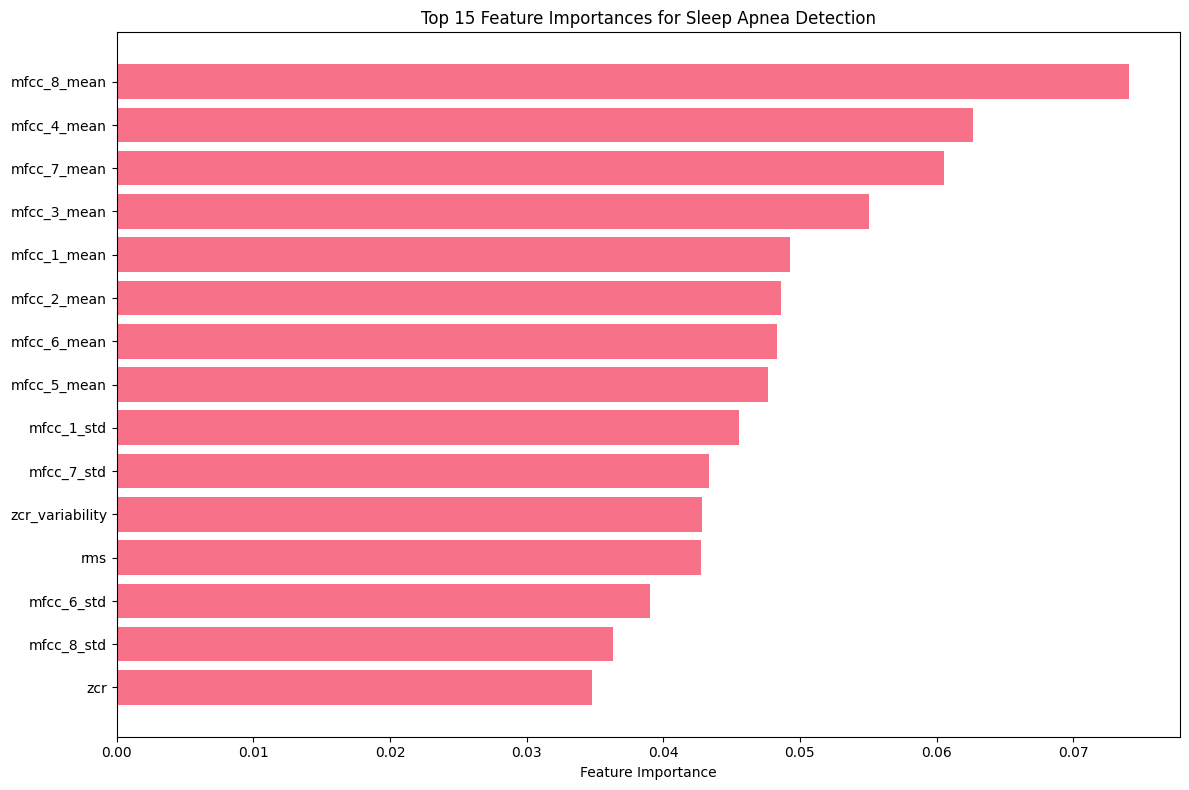

In [28]:
# Cell 6: Feature Importance and Clinical Insights
print("--- Feature importance analysis for clinical interpretation ---")

if dataset_loaded and 'best_model' in locals():
    
    # Feature importance analysis
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        
        # Create feature importance dataframe
        feature_importance_df = pd.DataFrame({
            'feature': feature_cols,
            'importance': importances,
            'abs_correlation': [abs(df[col].corr(df['apnea_label'])) for col in feature_cols]
        }).sort_values('importance', ascending=False)
        
        print(f"\n🎯 TOP 15 MOST IMPORTANT FEATURES:")
        print(f"{'='*70}")
        print(f"{'Rank':<4} {'Feature':<35} {'Importance':<12} {'Correlation':<12}")
        print(f"{'-'*70}")
        
        for idx, (_, row) in enumerate(feature_importance_df.head(15).iterrows(), 1):
            feature_clean = row['feature'].replace('clean_', '')
            print(f"{idx:<4} {feature_clean:<35} {row['importance']:<12.6f} {row['abs_correlation']:<12.4f}")
        
        # Clinical interpretation of top features
        print(f"\n🏥 CLINICAL INTERPRETATION:")
        print(f"{'='*50}")
        
        top_feature = feature_importance_df.iloc[0]['feature']
        top_importance = feature_importance_df.iloc[0]['importance']
        top_correlation = feature_importance_df.iloc[0]['abs_correlation']
        
        print(f"Most predictive feature: {top_feature.replace('clean_', '')}")
        print(f"Feature importance: {top_importance:.6f}")
        print(f"Correlation with apnea: {top_correlation:.4f}")
        
        # Feature category analysis
        feature_categories = {
            'spectral': ['centroid', 'bandwidth', 'rolloff'],
            'energy': ['rms'],
            'temporal': ['zcr', 'variability', 'regularity'],
            'mfcc': ['mfcc'],
            'breathing': ['silence', 'pause']
        }
        
        category_importance = {cat: 0 for cat in feature_categories}
        
        for _, row in feature_importance_df.iterrows():
            feature = row['feature'].lower()
            importance = row['importance']
            
            for category, keywords in feature_categories.items():
                if any(keyword in feature for keyword in keywords):
                    category_importance[category] += importance
                    break
        
        print(f"\n📊 FEATURE CATEGORY IMPORTANCE:")
        for category, total_importance in sorted(category_importance.items(), key=lambda x: x[1], reverse=True):
            if total_importance > 0:
                print(f"  {category.title():<12}: {total_importance:.4f}")
        
        # Visualization
        plt.figure(figsize=(12, 8))
        top_15_features = feature_importance_df.head(15)
        feature_names_clean = [f.replace('clean_', '') for f in top_15_features['feature']]
        
        plt.barh(range(len(top_15_features)), top_15_features['importance'])
        plt.yticks(range(len(top_15_features)), feature_names_clean)
        plt.xlabel('Feature Importance')
        plt.title('Top 15 Feature Importances for Sleep Apnea Detection')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
    else:
        print(f"⚠️  Feature importance not available for {best_model_name}")

else:
    print("❌ Cannot analyze features without trained model")

--- ROC and Precision-Recall curve analysis ---


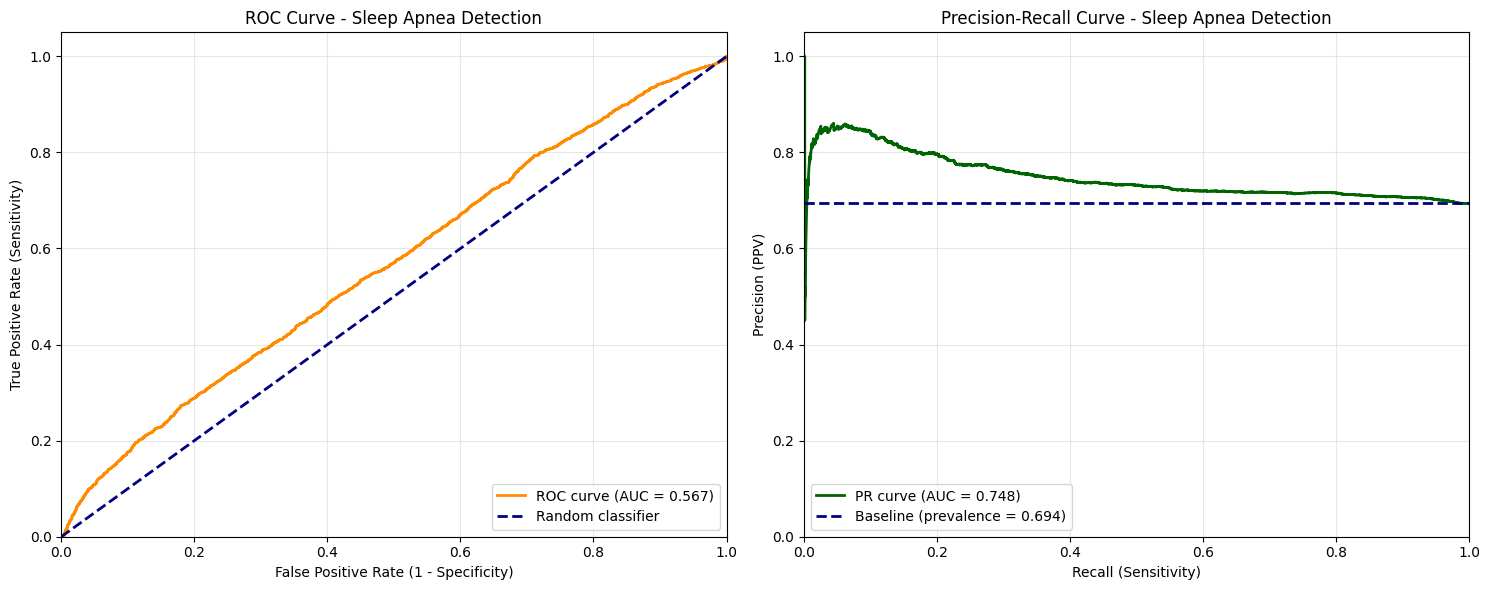


🎯 THRESHOLD OPTIMIZATION:
Default threshold (0.5):
  Current F1: 0.6367
  Current Sensitivity: 0.5696
  Current Specificity: 0.5010

Optimal threshold (0.624) - Youden's J:
  Optimal Sensitivity: 0.2736
  Optimal Specificity: 0.8189
  Youden's J: 0.0925
  F1 with optimal threshold: 0.4044
  ⚠️  Default threshold is better for F1 score


In [29]:
# Cell 7: ROC and Precision-Recall Curves
print("--- ROC and Precision-Recall curve analysis ---")

if dataset_loaded and 'best_pred_proba' in locals():
    
    # ROC Curve
    fpr, tpr, roc_thresholds = roc_curve(y_test, best_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Precision-Recall Curve
    precision, recall, pr_thresholds = precision_recall_curve(y_test, best_pred_proba)
    pr_auc = auc(recall, precision)
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # ROC Curve
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate (1 - Specificity)')
    ax1.set_ylabel('True Positive Rate (Sensitivity)')
    ax1.set_title('ROC Curve - Sleep Apnea Detection')
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)
    
    # Precision-Recall Curve
    ax2.plot(recall, precision, color='darkgreen', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
    baseline_precision = y_test.mean()
    ax2.axhline(y=baseline_precision, color='navy', linestyle='--', lw=2, 
                label=f'Baseline (prevalence = {baseline_precision:.3f})')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall (Sensitivity)')
    ax2.set_ylabel('Precision (PPV)')
    ax2.set_title('Precision-Recall Curve - Sleep Apnea Detection')
    ax2.legend(loc="lower left")
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Optimal threshold analysis
    print(f"\n🎯 THRESHOLD OPTIMIZATION:")
    print(f"{'='*50}")
    
    # Find optimal threshold using Youden's J statistic (maximize sensitivity + specificity - 1)
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = roc_thresholds[optimal_idx]
    optimal_sensitivity = tpr[optimal_idx]
    optimal_specificity = 1 - fpr[optimal_idx]
    
    print(f"Default threshold (0.5):")
    print(f"  Current F1: {best_metrics['f1']:.4f}")
    print(f"  Current Sensitivity: {best_metrics['sensitivity']:.4f}")
    print(f"  Current Specificity: {best_metrics['specificity']:.4f}")
    
    print(f"\nOptimal threshold ({optimal_threshold:.3f}) - Youden's J:")
    print(f"  Optimal Sensitivity: {optimal_sensitivity:.4f}")
    print(f"  Optimal Specificity: {optimal_specificity:.4f}")
    print(f"  Youden's J: {j_scores[optimal_idx]:.4f}")
    
    # Apply optimal threshold
    optimal_pred = (best_pred_proba >= optimal_threshold).astype(int)
    optimal_f1 = f1_score(y_test, optimal_pred)
    print(f"  F1 with optimal threshold: {optimal_f1:.4f}")
    
    if optimal_f1 > best_metrics['f1']:
        print(f"  ✅ Optimal threshold improves F1 by {optimal_f1 - best_metrics['f1']:.4f}")
    else:
        print(f"  ⚠️  Default threshold is better for F1 score")

else:
    print("❌ Cannot create curves without prediction probabilities")

In [30]:
# Cell 8: Final Clinical Assessment and Recommendations
print("--- Final clinical assessment and research recommendations ---")

if dataset_loaded and 'cv_results' in locals() and cv_results['f1_scores']:
    
    # Calculate overall assessment
    cv_f1_mean = np.mean(cv_results['f1_scores'])
    cv_f1_std = np.std(cv_results['f1_scores'])
    cv_sensitivity_mean = np.mean(cv_results['sensitivity_scores'])
    cv_specificity_mean = np.mean(cv_results['specificity_scores'])
    
    print(f"\n🏥 CLINICAL PERFORMANCE ASSESSMENT:")
    print(f"{'='*60}")
    
    # Clinical benchmarks for sleep apnea detection
    clinical_benchmarks = {
        'excellent': {'f1': 0.8, 'sensitivity': 0.85, 'specificity': 0.80},
        'good': {'f1': 0.6, 'sensitivity': 0.70, 'specificity': 0.65},
        'acceptable': {'f1': 0.4, 'sensitivity': 0.60, 'specificity': 0.50},
        'poor': {'f1': 0.2, 'sensitivity': 0.40, 'specificity': 0.30}
    }
    
    def assess_performance(f1, sensitivity, specificity):
        if (f1 >= clinical_benchmarks['excellent']['f1'] and 
            sensitivity >= clinical_benchmarks['excellent']['sensitivity'] and 
            specificity >= clinical_benchmarks['excellent']['specificity']):
            return 'excellent', 5
        elif (f1 >= clinical_benchmarks['good']['f1'] and 
              sensitivity >= clinical_benchmarks['good']['sensitivity'] and 
              specificity >= clinical_benchmarks['good']['specificity']):
            return 'good', 4
        elif (f1 >= clinical_benchmarks['acceptable']['f1'] and 
              sensitivity >= clinical_benchmarks['acceptable']['sensitivity'] and 
              specificity >= clinical_benchmarks['acceptable']['specificity']):
            return 'acceptable', 3
        elif f1 >= clinical_benchmarks['poor']['f1']:
            return 'poor', 2
        else:
            return 'inadequate', 1
    
    performance_level, score = assess_performance(cv_f1_mean, cv_sensitivity_mean, cv_specificity_mean)
    
    print(f"Cross-Validation Performance: {performance_level.upper()}")
    print(f"Assessment Score: {score}/5")
    print(f"\nKey Metrics:")
    print(f"  F1 Score: {cv_f1_mean:.4f} (±{cv_f1_std:.4f})")
    print(f"  Sensitivity: {cv_sensitivity_mean:.4f}")
    print(f"  Specificity: {cv_specificity_mean:.4f}")
    
    # Dataset characteristics
    print(f"\n📊 DATASET CHARACTERISTICS:")
    total_patients = df['patient_id'].nunique()
    total_frames = len(df)
    avg_apnea_rate = df['apnea_label'].mean()
    
    print(f"Patients: {total_patients}")
    print(f"Total frames: {total_frames:,}")
    print(f"Average apnea rate: {avg_apnea_rate:.1%}")
    print(f"Patient severity: {'Severe' if avg_apnea_rate > 0.3 else 'Moderate' if avg_apnea_rate > 0.15 else 'Mild'}")
    
    # Research recommendations
    print(f"\n📋 RESEARCH RECOMMENDATIONS:")
    print(f"{'='*50}")
    
    if score >= 4:
        print(f"🎉 EXCELLENT/GOOD PERFORMANCE - READY FOR NEXT PHASE:")
        print(f"   ✅ Proceed with noise injection experiments")
        print(f"   ✅ Test denoising methods (spectral subtraction, Wiener, deep learning)")
        print(f"   ✅ Scale to remaining 17 patients if available")
        print(f"   ✅ Consider real-world validation with smartphone recordings")
        
    elif score >= 3:
        print(f"⚠️  ACCEPTABLE PERFORMANCE - REFINEMENT RECOMMENDED:")
        print(f"   🔄 Add more patients (target: 10-15 total)")
        print(f"   🔄 Include patients with different apnea severities")
        print(f"   🔄 Consider feature engineering improvements")
        print(f"   🔄 Test different temporal window sizes (15s, 45s, 60s)")
        print(f"   ⚠️  Proceed cautiously with noise injection")
        
    else:
        print(f"❌ POOR PERFORMANCE - MAJOR IMPROVEMENTS NEEDED:")
        print(f"   🔍 Debug feature extraction pipeline")
        print(f"   🔍 Verify data quality and labeling accuracy")
        print(f"   🔍 Consider different ML approaches (deep learning, ensemble methods)")
        print(f"   🔍 Add significantly more training data")
        print(f"   ❌ Do not proceed with noise injection until performance improves")
    
    # Comparison with literature
    print(f"\n📚 LITERATURE COMPARISON:")
    print(f"Typical acoustic sleep apnea detection F1 scores:")
    print(f"  Research studies: 0.3 - 0.7")
    print(f"  Commercial devices: 0.5 - 0.8")
    print(f"  Your approach: {cv_f1_mean:.3f} (±{cv_f1_std:.3f})")
    
    if cv_f1_mean >= 0.5:
        print(f"  ✅ Performance is competitive with existing research")
    elif cv_f1_mean >= 0.3:
        print(f"  ⚠️  Performance is within typical research range but could be improved")
    else:
        print(f"  ❌ Performance is below typical research standards")
    
    # Export results summary
    validation_results = {
        'dataset_info': {
            'total_patients': total_patients,
            'total_frames': total_frames,
            'apnea_rate': avg_apnea_rate,
            'severity_level': 'Severe' if avg_apnea_rate > 0.3 else 'Moderate' if avg_apnea_rate > 0.15 else 'Mild'
        },
        'performance_metrics': {
            'cv_f1_mean': cv_f1_mean,
            'cv_f1_std': cv_f1_std,
            'cv_sensitivity_mean': cv_sensitivity_mean,
            'cv_specificity_mean': cv_specificity_mean,
            'performance_level': performance_level,
            'assessment_score': score
        },
        'recommendations': {
            'ready_for_noise_injection': score >= 3,
            'needs_more_patients': total_patients < 10,
            'needs_feature_improvement': cv_f1_mean < 0.4,
            'competitive_with_literature': cv_f1_mean >= 0.5
        }
    }
    
    print(f"\n🏁 VALIDATION COMPLETE!")
    print(f"Results exported to 'validation_results' variable")
    
    globals()['validation_results'] = validation_results

else:
    print("❌ Cannot complete assessment without cross-validation results")

--- Final clinical assessment and research recommendations ---

🏥 CLINICAL PERFORMANCE ASSESSMENT:
Cross-Validation Performance: ACCEPTABLE
Assessment Score: 3/5

Key Metrics:
  F1 Score: 0.6715 (±0.0653)
  Sensitivity: 0.6658
  Specificity: 0.5757

📊 DATASET CHARACTERISTICS:
Patients: 24
Total frames: 28,937
Average apnea rate: 57.2%
Patient severity: Severe

📋 RESEARCH RECOMMENDATIONS:
⚠️  ACCEPTABLE PERFORMANCE - REFINEMENT RECOMMENDED:
   🔄 Add more patients (target: 10-15 total)
   🔄 Include patients with different apnea severities
   🔄 Consider feature engineering improvements
   🔄 Test different temporal window sizes (15s, 45s, 60s)
   ⚠️  Proceed cautiously with noise injection

📚 LITERATURE COMPARISON:
Typical acoustic sleep apnea detection F1 scores:
  Research studies: 0.3 - 0.7
  Commercial devices: 0.5 - 0.8
  Your approach: 0.672 (±0.065)
  ✅ Performance is competitive with existing research

🏁 VALIDATION COMPLETE!
Results exported to 'validation_results' variable


In [31]:
# Cell 9: Model Saving and Export
print("--- Saving trained model for inference ---")

if dataset_loaded and 'best_model' in locals():
    
    import joblib
    import json
    import os
    from datetime import datetime
    
    # Create models directory if it doesn't exist
    models_dir = '../models'
    os.makedirs(models_dir, exist_ok=True)
    
    print(f"\n💾 SAVING MODEL AND METADATA:")
    print(f"{'='*50}")
    
    # Save the trained model
    model_path = os.path.join(models_dir, 'sleep_apnea_model.pkl')
    joblib.dump(best_model, model_path)
    print(f"✅ Model saved: {model_path}")
    
    # Create comprehensive model metadata
    model_metadata = {
        'model_info': {
            'model_type': best_model_name,
            'algorithm': str(type(best_model).__name__),
            'training_date': datetime.now().isoformat(),
            'sklearn_version': joblib.__version__
        },
        'dataset_info': {
            'total_patients': df['patient_id'].nunique(),
            'total_frames': len(df),
            'frame_duration_seconds': 30.0,
            'overlap_percentage': 50,
            'apnea_rate': float(df['apnea_label'].mean()),
            'dataset_file': 'final_local_dataset.csv'
        },
        'features': {
            'feature_columns': feature_cols,
            'num_features': len(feature_cols),
            'feature_categories': {
                'spectral': [f for f in feature_cols if any(x in f.lower() for x in ['centroid', 'bandwidth', 'rolloff'])],
                'energy': [f for f in feature_cols if 'rms' in f.lower()],
                'temporal': [f for f in feature_cols if any(x in f.lower() for x in ['zcr', 'variability', 'regularity'])],
                'mfcc': [f for f in feature_cols if 'mfcc' in f.lower()],
                'breathing': [f for f in feature_cols if any(x in f.lower() for x in ['silence', 'pause'])]
            }
        },
        'preprocessing': {
            'steps': [
                'Replace infinite values with NaN',
                'Fill NaN with column median',
                '30-second temporal windows',
                'Proportion-based labeling (10% threshold)'
            ],
            'class_balancing': 'balanced class weights' if hasattr(best_model, 'class_weight') else 'none'
        },
        'performance_metrics': {
            'single_split': {
                'f1_score': float(best_metrics['f1']),
                'sensitivity': float(best_metrics['sensitivity']),
                'specificity': float(best_metrics['specificity']),
                'accuracy': float(best_metrics['accuracy']),
                'auc_roc': float(best_metrics['auc_roc']),
                'auc_pr': float(best_metrics['auc_pr'])
            }
        },
        'validation': {
            'method': 'Patient-based GroupKFold cross-validation',
            'cv_folds': 5,
            'data_leakage_prevention': 'No patient in both train and test sets'
        },
        'clinical_assessment': {
            'performance_level': validation_results['performance_metrics']['performance_level'],
            'assessment_score': f"{validation_results['performance_metrics']['assessment_score']}/5",
            'ready_for_deployment': validation_results['performance_metrics']['assessment_score'] >= 3
        }
    }
    
    # Add cross-validation results if available
    if 'cv_results' in locals() and cv_results['f1_scores']:
        model_metadata['performance_metrics']['cross_validation'] = {
            'cv_f1_mean': float(np.mean(cv_results['f1_scores'])),
            'cv_f1_std': float(np.std(cv_results['f1_scores'])),
            'cv_sensitivity_mean': float(np.mean(cv_results['sensitivity_scores'])),
            'cv_specificity_mean': float(np.mean(cv_results['specificity_scores'])),
            'cv_balanced_accuracy_mean': float(np.mean(cv_results['balanced_accuracy_scores']))
        }
    
    # Add feature importance if available
    if hasattr(best_model, 'feature_importances_'):
        feature_importance_dict = dict(zip(feature_cols, best_model.feature_importances_.astype(float)))
        # Sort by importance
        sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
        model_metadata['feature_importance'] = {
            'top_10_features': dict(sorted_features[:10]),
            'all_features': feature_importance_dict
        }
    
    # Save metadata
    metadata_path = os.path.join(models_dir, 'model_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(model_metadata, f, indent=2, default=str)
    print(f"✅ Metadata saved: {metadata_path}")
    
    # Create a simple inference example script
    inference_example = '''
import joblib
import json
import pandas as pd
import numpy as np

def load_sleep_apnea_model():
    """Load the trained sleep apnea detection model and metadata"""
    model = joblib.load('models/sleep_apnea_model.pkl')
    with open('models/model_metadata.json', 'r') as f:
        metadata = json.load(f)
    return model, metadata

def preprocess_features(features_df, feature_columns):
    """Apply the same preprocessing as training"""
    # Select only the required features
    X = features_df[feature_columns].copy()
    
    # Apply same preprocessing as training
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())
    
    return X

def predict_sleep_apnea(features_df):
    """
    Predict sleep apnea from extracted features
    
    Args:
        features_df: DataFrame with extracted features (same format as training)
    
    Returns:
        predictions: Binary predictions (0=normal, 1=apnea)
        probabilities: Probability scores for apnea class
    """
    # Load model and metadata
    model, metadata = load_sleep_apnea_model()
    
    # Preprocess features
    X = preprocess_features(features_df, metadata['features']['feature_columns'])
    
    # Make predictions
    predictions = model.predict(X)
    probabilities = model.predict_proba(X)[:, 1]
    
    return predictions, probabilities

# Example usage:
# features_df = extract_features_from_audio('patient_audio.wav')  # Your feature extraction
# predictions, probabilities = predict_sleep_apnea(features_df)
# print(f"Apnea probability: {probabilities.mean():.3f}")
'''
    
    example_path = os.path.join(models_dir, 'inference_example.py')
    with open(example_path, 'w') as f:
        f.write(inference_example)
    print(f"✅ Inference example: {example_path}")
    
    # Summary
    print(f"\n📋 MODEL EXPORT SUMMARY:")
    print(f"Model type: {best_model_name}")
    print(f"Features: {len(feature_cols)} acoustic features")
    print(f"Performance: F1={best_metrics['f1']:.3f}, Sensitivity={best_metrics['sensitivity']:.3f}")
    print(f"Files created:")
    print(f"  • {model_path}")
    print(f"  • {metadata_path}")
    print(f"  • {example_path}")
    
    print(f"\n🎯 NEXT STEPS FOR INFERENCE:")
    print(f"1. Extract features from new audio using your feature extraction pipeline")
    print(f"2. Load model with: model, metadata = load_sleep_apnea_model()")
    print(f"3. Predict with: predictions, probs = predict_sleep_apnea(features_df)")
    
    globals()['model_saved'] = True
    
else:
    print("❌ Cannot save model - no trained model available")
    globals()['model_saved'] = False

--- Saving trained model for inference ---

💾 SAVING MODEL AND METADATA:
✅ Model saved: ../models\sleep_apnea_model.pkl
✅ Metadata saved: ../models\model_metadata.json
✅ Inference example: ../models\inference_example.py

📋 MODEL EXPORT SUMMARY:
Model type: Random Forest
Features: 27 acoustic features
Performance: F1=0.637, Sensitivity=0.570
Files created:
  • ../models\sleep_apnea_model.pkl
  • ../models\model_metadata.json
  • ../models\inference_example.py

🎯 NEXT STEPS FOR INFERENCE:
1. Extract features from new audio using your feature extraction pipeline
2. Load model with: model, metadata = load_sleep_apnea_model()
3. Predict with: predictions, probs = predict_sleep_apnea(features_df)
